In [1]:
#Math Part
import numpy as np
import pandas as pd

#Graph
import matplotlib.pyplot as plt

import importlib
import circuit
import encoding
import qsvm
import fitness
import gsvm
importlib.reload(circuit)
importlib.reload(encoding)
importlib.reload(qsvm)
importlib.reload(fitness)
importlib.reload(gsvm)

import pandas as pd
import time

#def evol(output="sample_iot_result_n5.csv"):
output="sample_iot_result_n5.csv"
iot_data = pd.read_csv('sample_iot_data.csv')
y = iot_data['pump'].values
X = iot_data[['moisture','temp']].values
start = time.time()
pop, pareto, logbook = gsvm.gsvm(nqubits=3, depth=3, nparameters=2,
                            X=X, y=y, weights=[-1.0,1.0],
                            mu=50,lambda_=10, ngen=200)
print(f'Simulation finished after {time.time()-start} seconds')
print(f'\nGenetic-algorithm output ({output})')
#print('generation, individual, gates/qubit, accuracy')
print('---------------------------------------------')
# print(logbook)
with open(output, "w") as f:
    for ide, ind in enumerate(pareto):
        genes=''.join(str(i) for i in list(ind))
        gates, acc = ind.fitness.values
        line = f'{ide},"{genes}",{gates},{acc}'
        f.write(line)
        f.write('\n')
        print(line)
                
#evol()

String: 101100110110011111111111110110101100010101010
 -> accuracy = 0.925, gates = 6.0,recall = 1.0
String: 011010101111111100111000001000001100000100001
 -> accuracy = 0.9, gates = 8.0,recall = 1.0
String: 111100100000111100011111011010001001010101111
 -> accuracy = 0.9, gates = 8.0,recall = 1.0
String: 101000001011001111101010001000010110001010001
 -> accuracy = 0.875, gates = 4.0,recall = 1.0
String: 011110010011011010001010001001100001001111010
 -> accuracy = 0.75, gates = 5.0,recall = 1.0
String: 111101011001101110010010001010101100000111011
 -> accuracy = 0.875, gates = 5.0,recall = 1.0
String: 101110011010011111001010011100110000101100100
 -> accuracy = 0.925, gates = 7.0,recall = 1.0
String: 011100011110001101010101001111011110101010000
 -> accuracy = 0.925, gates = 7.0,recall = 1.0
String: 101011100000001101000011011010001010010001101
 -> accuracy = 0.925, gates = 8.0,recall = 1.0
String: 011011001100110000110000011000110110110000000
 -> accuracy = 0.95, gates = 8.0,recall = 

In [3]:
iot_result = pd.read_csv('sample_iot_result_n5.csv',header=None)

def ordenar_salidas_pareto(dataframe):
    dataframe.columns=['ind','circ','gates','acc']
    dataframe.sort_values(['acc','gates'], ascending=[False,False],inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.pop('index')
    return dataframe

iot_salidas = ordenar_salidas_pareto(iot_result)
iot_salidas # Queremos ver el primer circuito del dataframe yya ordenado por accuracy (mejor ind)

,ind,circ,gates,acc
0,509,100000001001011100110001001100111011100111001,4.000000,1.000
1,485,111001100001011101100111110101010111100011011,1.300417,0.975
2,486,110101000101010101101001110110010011101011001,1.300417,0.975
3,487,111011101001011101100101110100111111100010101,1.300417,0.975
4,488,111010100001011101100101110100111111100010101,1.300417,0.975
...,...,...,...,...
505,261,110111100001001101100101110111010011010011001,0.000000,0.750
506,262,110001100001001101010101110110110111101110101,0.000000,0.750
507,263,110111100001011101100101110100010011011011001,0.000000,0.750
508,264,110111100001011101100101110111010011010011001,0.000000,0.750


['10000', '00010', '01011', '10011', '00010', '01100', '11101', '11001', '11001']
6.0


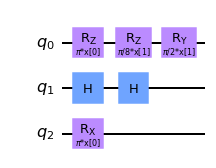

In [5]:
from qiskit.circuit import ParameterVector, QuantumCircuit, Parameter
from qiskit import execute, Aer, IBMQ, QuantumRegister, ClassicalRegister, BasicAer
# from qiskit.aqua import QuantumInstance
def coding_bits(b):
    c = [b[n:n+5] for n,i in enumerate(b) if n%5==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+5] for n,i in enumerate(c_p) if n%5==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = np.pi / (2**n)
            gates['000'+suffix] = (self.make_H(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

import os
import psutil

class Fitness:

    def __init__(self, nqubits, nparameters, X, y, quantum_instance):
        self.nqubits = nqubits
        self.nparameters = nparameters
        self.cc = CircuitConversor(nqubits, nparameters)
        self.instance = quantum_instance
        self.X = X
        self.y = y

    def __call__(self, POP):
        try:
            return self.fitness(POP)
        except Exception as e:
            print(f'Exception happened during fitness():\n  {e}')
            process = psutil.Process(os.getpid())
            print(f'  RUSAGE_SELF: {process.memory_info()}')
        return 1000, 100000.0

    def fitness(self, POP):
        print('Invoked fitness')
        #Convertimos el individuo en el fenotipo (ansatz)
        fm, puertas = self.cc(coding_bits(POP))
        
cc = CircuitConversor(nqubits=3, nparameters=2)
fm, puertas = cc(coding_bits(iot_salidas.circ[0]))
print(puertas)
fm.draw(output='mpl')

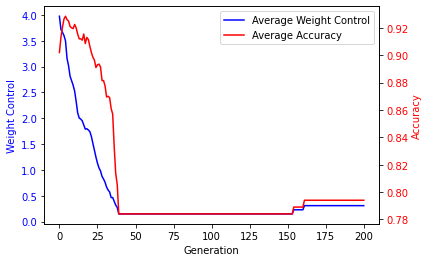

<Figure size 600x400 with 0 Axes>

In [8]:
gen = logbook.select("gen")
wc = logbook.chapters["wc"].select("media")
acc = logbook.chapters["acc"].select("media")

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
plt.figure(dpi = 100)
line1 = ax1.plot(gen, wc ,"b-", label="Average Weight Control")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Weight Control", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, acc, "r-", label="Average Accuracy")
ax2.set_ylabel("Accuracy", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="best")

plt.show()